# Simple example of U-net for segmentation of steel surface defects

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2

import keras
from tensorflow.keras.layers import Conv2DTranspose

from keras.layers import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import Model
from keras import backend as K
from keras.layers import Lambda
from typing import DefaultDict
from glob import glob

In [3]:
tr = pd.read_csv(r"C:\Users\Nasem\Desktop\steelsdata\train.csv")
print(len(tr))
tr.head()

7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [7]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
print(len(df_train))
df_train.head(100)

7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
95,0360edfb8.jpg,3,174593 2 174849 5 175105 8 175169 4 175361 11 ...
96,036c4e5d2.jpg,1,75436 41 75640 122 75863 170 76104 185 76345 2...
97,036c7d18c.jpg,3,38 98 291 101 544 104 797 108 1050 111 1303 11...
98,037fca267.jpg,3,237522 5 237778 14 238034 23 238290 28 238545 ...


In [24]:
# set paths to train and test image datasets
TRAIN_PATH = r"C:\Users\Nasem\Desktop\steelsdata\train_images\\"
TEST_PATH = r"C:\Users\Nasem\Desktop\steelsdata\test_images\\"

# load dataframe with train labels
train_df = pd.read_csv(r"C:\Users\Nasem\Desktop\steelsdata\train.csv")
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))

There are 12568 images in the train set.
There are 5506 images in the test set.


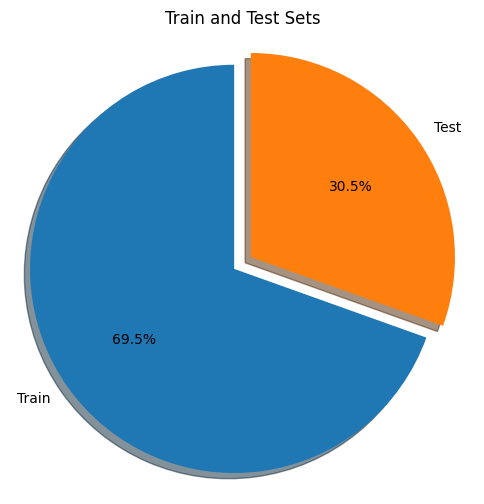

In [25]:
# plotting a pie chart which demonstrates train and test sets
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

In [17]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [18]:
img_size = 256


In [19]:
img_size = 256
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId'].iloc[i]
            img = cv2.imread( r"C:\Users\Nasem\Desktop\steelsdata\train_images\\"+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            img = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))
            
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [20]:
for x, y in keras_generator(40):
    break
    
print(x.shape, y.shape)

(40, 256, 256, 3) (40, 256, 256, 1)


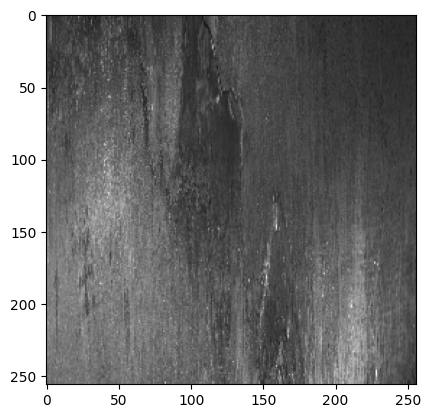

In [22]:
plt.imshow(x[3])


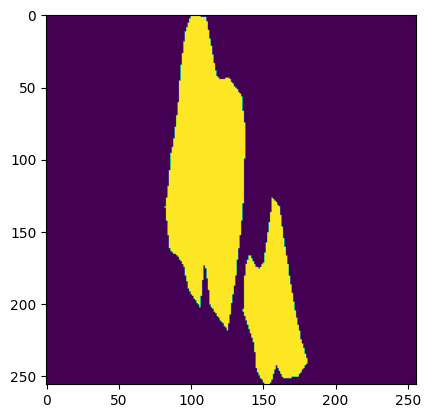

In [ ]:
plt.imshow(np.squeeze(y[3]))

In [17]:
#Model

inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
model_save_path = 'unnett.hdf5'

checkpoint = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True, monitor='loss')




In [15]:
%%time
# Fit model
batch_size = 16
results = model.fit(keras_generator(batch_size), 
                              steps_per_epoch=100,
                              epochs=20,
                             callbacks=[checkpoint]) 

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.2622
Epoch 1: loss improved from inf to 0.26219, saving model to unnett.hdf5


C:\Users\Nasem\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 744s 7s/step - loss: 0.2622
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1968
Epoch 2: loss improved from 0.26219 to 0.19681, saving model to unnett.hdf5
100/100 [==============================] - 830s 8s/step - loss: 0.1968
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.1233
Epoch 3: loss improved from 0.19681 to 0.12334, saving model to unnett.hdf5
100/100 [==============================] - 836s 8s/step - loss: 0.1233
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0541
Epoch 4: loss improved from 0.12334 to 0.05405, saving model to unnett.hdf5
100/100 [==============================] - 837s 8s/step - loss: 0.0541
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 0.0289
Epoch 5: loss improved from 0.05405 to 0.02894, saving model to unnett.hdf5
100/100 [==============================] - 837s 8s/step - loss: 0.0289
Epoch 6/20
100/100 [=============

In [17]:
model.save('steel_model.h5')

C:\Users\Nasem\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


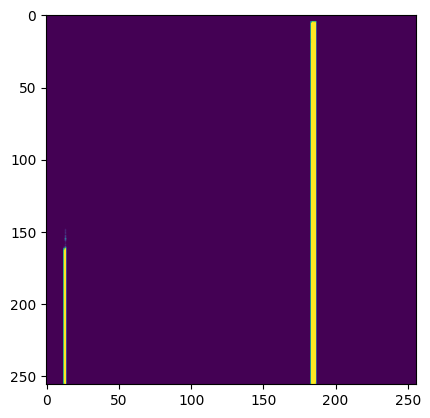

In [12]:
from keras.models import load_model
modl = load_model('steel_model.h5')
                   
pred = modl.predict(x)
plt.imshow(np.squeeze(pred[1]))

In [25]:
testfiles=os.listdir("../input/test_images/")
len(testfiles)

5506

In [26]:
%%time
test_img = []
for fn in tqdm_notebook(testfiles):
        img = cv2.imread( '../input/test_images/'+fn )
        img = cv2.resize(img,(img_size,img_size))       
        test_img.append(img)

<timed exec>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5506 [00:00<?, ?it/s]

CPU times: user 28.1 s, sys: 1.72 s, total: 29.8 s
Wall time: 1min 1s


In [27]:
%%time
predict = model.predict(np.asarray(test_img))
print(len(predict))

173/173 [==============================] - 9s 42ms/step
5506
CPU times: user 11.1 s, sys: 2.47 s, total: 13.5 s
Wall time: 13.1 s


In [28]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [29]:
%%time
pred_rle = []
for img in predict[:200]:      
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    pred_rle.append(mask2rle(tmp))

CPU times: user 3min 46s, sys: 0 ns, total: 3min 46s
Wall time: 3min 46s


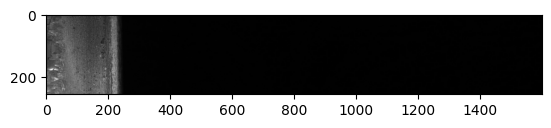

In [30]:
img_t = cv2.imread( '../input/test_images/'+ testfiles[1])
plt.imshow(img_t)

In [92]:
import sys
print(sys.version)


3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


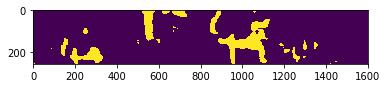

In [83]:
mask_t = rle2mask(pred_rle[45], img.shape)
plt.imshow(mask_t)

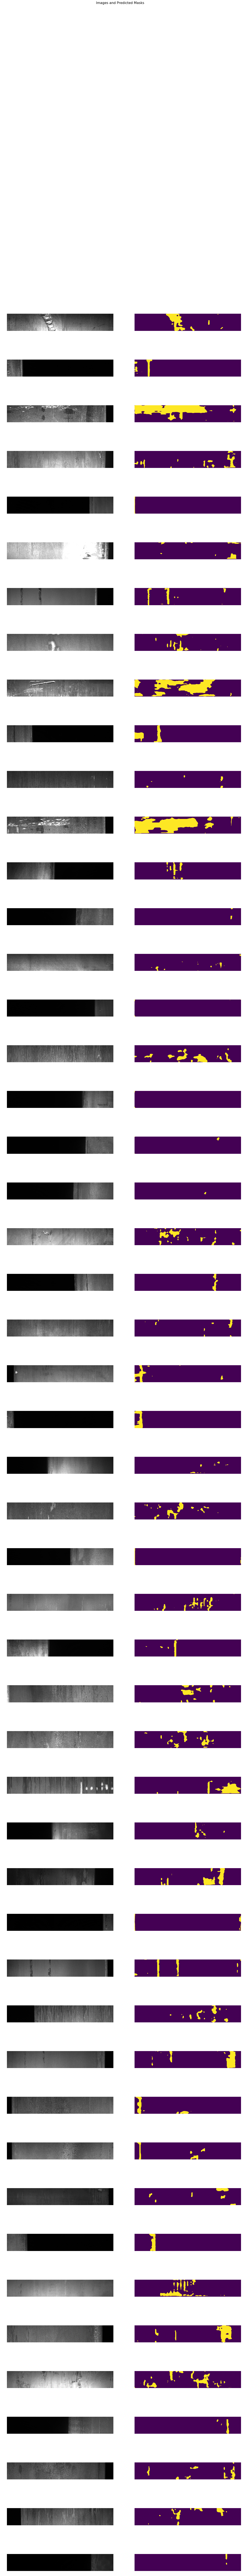

In [88]:
import matplotlib.pyplot as plt
import cv2

# Assuming you have a list of test files (testfiles) and predicted masks (pred_rle)

# Create a subplot with two columns to display images and masks side by side
plt.figure(figsize=(20, 200))  # Adjust the figure height for 50 images
plt.suptitle('Images and Predicted Masks', fontsize=16)

num_images_to_display = 50  # Number of images to display

for i in range(num_images_to_display):  # Display the first 50 images
    plt.subplot(num_images_to_display, 2, 2 * i + 1)  # Left column for images
    img_t = cv2.imread( '../input/test_images/' + testfiles[i])
    plt.imshow(img_t)
    plt.axis('off')
    plt.gca().set_aspect('equal')  # Set the aspect ratio to 'equal' for larger images

    plt.subplot(num_images_to_display, 2, 2 * i + 2)  # Right column for masks
    mask_t = rle2mask(pred_rle[i], img.shape)  # Assuming you have a function rle2mask
    plt.imshow(mask_t, cmap='viridis')  # Adjust the colormap as needed
    plt.axis('off')
    plt.gca().set_aspect('equal')  # Set the aspect ratio to 'equal' for larger masks

plt.show()




In [ ]:
sub = pd.read_csv( '../input/sample_submission.csv' )
sub.head()

In [ ]:
%%time
for fn, rle in zip(testfiles, pred_rle):
    sub['EncodedPixels'][sub['ImageId_ClassId'].apply(lambda x: x.split('_')[0]) == fn] = rle

In [ ]:
sub.head(8)

In [ ]:
img_s = cv2.imread( '../input/test_images/'+ sub['ImageId_ClassId'][16].split('_')[0])
plt.imshow(img_s)

In [ ]:
mask_s = rle2mask(sub['EncodedPixels'][16], (256, 1600))
plt.imshow(mask_s)

In [ ]:
sub.to_csv('submission.csv', index=False)